Links to other notebooks in the same folder:
<a href='http://pivotal.io/data-science'><img src='https://raw.githubusercontent.com/crawles/Logos/master/Pivotal_TealOnWhite.png' width='200px' align='right'></a>

<nav class = "navbar navbar-light bg-faded">
    <ul class = "nav navbar-nav">
        <li class = "">
            <a class = "nav-link">notebook1</a>
        </li>
        <li class = "">
            <a class = "nav-link">notebook2</a>
        </li>
        <li class = "">
            <a class = "nav-link">notebook3</a>
        </li>
        

# Load Libraries and Set Default Settings

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from IPython.core.display import display, HTML
import os
import sys
import urllib

from IPython.core.magic import register_line_magic, register_cell_magic, register_line_cell_magic
from IPython.display import display
from IPython.display import HTML
%matplotlib inline
# If we want to move the graph
# %matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2
import seaborn as sns

# Credentials file to connect to database
import credentials
from sql_functions import *

/Users/gregorytam/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Changes logo to a Pivotal logo
jPrefs = urllib.urlopen("https://raw.githubusercontent.com/crawles/Logos/master/jupyterPrefs.js").read()
HTML('<script>{}</script>'.format(jPrefs))

In [3]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
mpl.rcParams['figure.figsize'] = (10, 7)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['figure.titlesize'] = 26
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

# Set Seaborn Colours
blue, green, red, purple, yellow, cyan = sns.color_palette()

# Connect to Database

In [4]:
conn = psycopg2.connect(database=credentials.database,
                        user=credentials.user,
                        password=credentials.password,
                        host=credentials.host
                       )
conn.autocommit = True

# Define magic functions - helpful for interacting with cluster

In [5]:
@register_cell_magic
def readsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL), 
    and execute it using the connection object to the backend 
    database. The resulting pandas DataFrame is rendered inline 
    below the cell using IPython.display. You'd use this for SELECT.
    
    Returns a DataFrame with the name specified in the magic
    function. If this is not specified, then the DataFrame
    is called _df.
    """
    # Use the global connection object defined above.
    global conn
    table_name = line
    # If there is more than one table name specified,
    # throw an exception.
    if len(table_name.split()) > 1:
        raise Exception('More than one table name specified')

    if len(table_name.split()) > 0:
        # If a table name is specified, store it as that
        globals()[table_name] = psql.read_sql(cell.format(**globals()), conn)
        display(globals()[table_name])

    else:
        # Otherwise, call it _df
        global _df
        _df = psql.read_sql(cell.format(**globals()), conn)
        display(_df)

    
@register_cell_magic
def execsql(line, cell):
    """
    Extract the code in the specific cell (should be valid SQL),
    and execute it using the connection object to the backend 
    database. You'd use this for CREATE/UPDATE/DELETE.
    """
    # Use the global connection object defined above.
    global conn
    psql.execute(cell.format(**globals()), conn)

# We delete these to avoid name conflicts for automagic to work
del execsql, readsql

# Defining our Functions

We can calculate our histogram and scatterplot bins via the formula: 
$$\text{bin_num}(x) = \frac{1}{n_{bins}} \left\lfloor \frac{x-\min(x)}{\max(x) - \min(x) + \varepsilon} * n_{bins} \right\rfloor  \times \left\{\max(x) - \min(x)\right\} + \min(x)$$
The variable $\varepsilon>0$ is a small number. This ensures that the fraction in the floor function is never equal to 1. This would happen in the case that $x$ is equal to the maximum and we would have a bin with potetially only one value (i.e., the max value).

In [6]:
def get_histogram_values(table_name, column_name, nbins=0, bin_width=0, cast_as=None, where_clause=''):
    """
    Takes a SQL table and creates histogram bin heights.
    Relevant parameters are either the number of bins
    or the width of each bin. Only one of these is specified.
    The other one must be left at its default value of 0
    or it will throw an error.
    
    Inputs:
    table_name - Name of the table in SQL
    column_name - Name of the column of interest
    nbins - Number of desired bins (Default: 0)
    bin_width - Width of each bin (Default: 0)
    
    If nbins and bin_width are left at 0, then nbins will
    be set to 25.
    
    cast_as - SQL type to cast as
    where_clause - A SQL where clause specifying any
                   filters
    """
    
    # Look for input errors
    if nbins != 0 and bin_width != 0:
        raise Exception('Both nbins and bin_width cannot be specified. Leave one at 0')
    elif bin_width < 0:
        raise Exception('bin_width must be positive.')
    elif nbins < 0:
        raise Exception('nbins must be positive.')
    elif nbins == 0 and bin_width == 0:
        # Default value if no options are specified
        nbins=25
        
    sql = '''
    SELECT column_name, data_type
      FROM information_schema.columns
     WHERE table_name = '{table_name}'
       AND column_name = '{column_name}'
    '''.format(table_name=table_name, column_name=column_name)
    info_df = psql.read_sql(sql, conn)
    
    if column_name in info_df['column_name'].tolist():
        if cast_as is None:
            is_category = (info_df[info_df.column_name == column_name]['data_type'] == 'text')[0]
        elif cast_as in ['timestamp', 'date', 'int', 'float', 'numeric']:  # If we want to cast it to a number
            is_category = False
    else:
        raise Exception(column_name + ' is not found in the table ' + table_name)
    
    # If cast_as is specified, we must create a cast string
    # to recast our columns. If not, we set it as a blank string.
    if cast_as is None:
        cast_string = ''
    else:
        cast_string = '::' + cast_as.upper()
    
    if is_category:
        sql = '''
        SELECT {column_name}, COUNT(*) AS freq
          FROM {table_name}
         GROUP BY {column_name}
         ORDER BY COUNT(*) DESC;
        '''.format(column_name=column_name, table_name=table_name)
    
    else:
        def _min_max_value(column_name):
            sql = '''
            SELECT MIN({col_name}{cast_as}), MAX({col_name}{cast_as})
              FROM {table_name}
             {where_clause};
            '''.format(col_name = column_name,
                       cast_as = cast_string,
                       table_name = table_name,
                       where_clause = where_clause
                      )
            return tuple(psql.read_sql(sql, conn).iloc[0])
        
        # Get min and max value of the column
        min_val, max_val = _min_max_value(column_name)
        
        # Get the span of the column
        span_value = max_val - min_val
        if bin_width == 0:
            bin_width = span_value/nbins
        
        # Form the SQL statement. The min_val must be taken
        # down by a small value because of rounding errors. 
        # If this is not taken into account, a column value
        # may be smaller than the min_value. We also must
        # deal with cases where the column name equals the max
        sql = '''
          WITH binned_table
            AS (SELECT FLOOR(({column_name}{cast_as} - {min_val})
                             /({max_val} - {min_val}) 
                             * {nbins}
                            )
                       /{nbins} * ({max_val} - {min_val}) 
                       + {min_val} AS bin_nbr
                  FROM {table_name}
                 {where_clause}
               )
        SELECT bin_nbr, COUNT(*) AS freq
          FROM binned_table
         GROUP BY bin_nbr
         ORDER BY bin_nbr;
        '''.format(column_name = column_name,
                   cast_as = cast_string,
                   nbins = nbins,
                   min_val = min_val - 1e-8,
                   max_val = max_val + 1e-8,
                   table_name = table_name,
                   where_clause = where_clause
                  )
    
    return psql.read_sql(sql, conn)

def get_scatterplot_values(table_name, column_name_x, column_name_y, nbins=(0, 0), bin_size=(0, 0), cast_x_as=None, cast_y_as=None):
    """
    Takes a SQL table and creates scatter plot bin values.
    This is the 2D version of get_histogram_values.
    Relevant parameters are either the number of bins
    or the size of each bin in both the x and y direction. 
    Only number of bins or size of the bins is specified.
    The other pair must be left at its default value of 0
    or it will throw an error.
    
    Inputs:
    table_name - Name of the table in SQL
    column_name - Name of the column of interest
    nbins - Number of desired bins for x and y direcitons (Default: (0, 0))
    bin_size - Size of each bin for x and y directions (Default: (0, 0))
    
    If nbins and bin_size are both left at (0, 0), then nbins will be
    set to (1000, 1000)
    
    cast_x_as - SQL type to cast x as
    cast_y_as - SQL type to cast y as
    """
    
    # Look for input errors
    if nbins != (0, 0) and bin_size != (0, 0):
        raise Exception('Both nbins and bin_size cannot be specified. Leave one at (0, 0).')
    elif bin_size[0] < 0 or bin_size[1] < 0:
        raise Exception('Bin dimensions must both be positive.')
    elif nbins[0] < 0 or nbins[1] < 0:
        raise Exception('Number of bin dimensions must both be positive')
    elif nbins == (0, 0) and bin_size == (0, 0):
        # Default value if no options are specified
        nbins = (1000, 1000)
    
    # If cast_x_as or cast_y_as is specified, we must create cast
    # strings to recast our columns. If not, we set them as 
    # blank strings.
    if cast_x_as is None:
        cast_x_string = ''
    else:
        cast_x_string = '::' + cast_x_as.upper()
        
    if cast_y_as is None:
        cast_y_string = ''
    else:
        cast_y_string = '::' + cast_y_as.upper()
        
    def _min_max_value(column_name, cast_as):
        sql = '''
        SELECT MIN({col_name}{cast_as}), MAX({col_name}{cast_as})
          FROM {table_name};
        '''.format(col_name=column_name, table_name=table_name, cast_as=cast_as)
        return tuple(psql.read_sql(sql, conn).iloc[0])
    
    # Get the min and max values for x and y directions
    min_val_x, max_val_x = _min_max_value(column_name_x, cast_as=cast_x_string)
    min_val_y, max_val_y = _min_max_value(column_name_y, cast_as=cast_y_string)
    
    # Get the span of values in the x and y direction
    span_values = (max_val_x - min_val_x, max_val_y - min_val_y)
    
    # Since the bins are generated using nbins, 
    # if only bin_size is specified, we can 
    # back calculate the number of bins that will
    # be used.
    if nbins == (0, 0):
        nbins = [i/j for i, j in zip(span_values, bin_size)]
    
    sql = '''
      WITH binned_table
        AS (SELECT FLOOR(({x_col}{cast_x_as} - {min_val_x})
                         /({max_val_x} - {min_val_x}) 
                         * {nbins_x}
                         )
                   /{nbins_x} * ({max_val_x} - {min_val_x}) 
                   + {min_val_x} AS bin_nbr_x,
                   FLOOR(({y_col}{cast_y_as} - {min_val_y})
                         /({max_val_y} - {min_val_y}) 
                         * {nbins_y}
                         )
                   /{nbins_y} * ({max_val_y} - {min_val_y}) 
                   + {min_val_y} AS bin_nbr_y
              FROM {table_name}
             WHERE {x_col} IS NOT NULL
               AND {y_col} IS NOT NULL
           )
    SELECT bin_nbr_x, bin_nbr_y, COUNT(*) AS freq
      FROM binned_table
     GROUP BY bin_nbr_x, bin_nbr_y
     ORDER BY bin_nbr_x, bin_nbr_y;
    '''.format(x_col = column_name_x,
               cast_x_as = cast_x_string,
               y_col = column_name_y,
               cast_y_as = cast_y_string,
               min_val_x = min_val_x - 1e-8,
               max_val_x = max_val_x + 1e-8,
               min_val_y = min_val_y - 1e-8,
               max_val_y = max_val_y + 1e-8,
               nbins_x = nbins[0],
               nbins_y = nbins[1],
               table_name = table_name
              )
    
    return psql.read_sql(sql, conn)    

In [7]:
def _create_weight_percentage(hist_df, normed=False):
    """Convert frequencies to percent"""
    if normed:
        return hist_df.freq/hist_df.freq.sum()
    else:
        return hist_df.freq

def plot_numeric_hists(hist_info, labels=[], nbins=10, null_at='left', log=False, normed=False):
    """
    Plots numerical histograms together. 
    
    Inputs:
    hist_info - A pandas DataFrame or a list of DataFrames
                which have two columns (bin_nbr and freq).
                The bin_nbr is the value of the histogram bin
                and the frequency is how many values fall in that
                bin.
    labels - A string (for one histogram) or list of strings
             which sets the labels for the histograms
    nbins - The desired number of bins
    null_at - Which side to set a null value column. Leave it
              empty to not include (Default: left)
    """
    
    # If hist_info is a DataFrame, convert it into a list
    # If it is a list, keep it as is
    if str(type(hist_info)) == "<class 'pandas.core.frame.DataFrame'>":
        hist_info = [hist_info]
    # If labels is a string, convert it to a list
    # If it is a list, keep it as is
    if type(labels) == "<type 'str'>":
        labels = [labels]

    # If any of the columns are null
    has_null = [df['bin_nbr'].isnull().any() for df in hist_info]
    
    # Add in weights (If normed, then weights will sum to 1)
    for df in hist_info:
        df['weights'] = _create_weight_percentage(df[['freq']], normed)
    
    # If there are nulls, determine the weights. Otherwise, set to 0.
    null_weights = [float(df[df['bin_nbr'].isnull()].weights)
                    if is_null else 0 
                    for is_null, df in zip(has_null, hist_info)]
    
    hist_info = [df.dropna() for df in hist_info]
    weights = [df.weights for df in hist_info]
    bin_nbrs = [df.bin_nbr for df in hist_info]
    
    if len(labels) > 0:
        n, bins, _ = plt.hist(x=bin_nbrs, weights=weights, label=labels, bins=nbins, log=log)
    else:
        n, bins, _ = plt.hist(x=bin_nbrs, weights=weights, bins=nbins, log=log)
    # Get the bin widths
    bin_width = bins[1] - bins[0]
    xticks, _ = plt.xticks()
    
    if null_at == 'left':
        if np.any(np.array(null_weights) > 0):
            for i in range(len(null_weights)):
                if len(null_weights) == 1:
                    sub_bin_width = bin_width
                    sub_bin_left = bins[0] - bin_width
                else:
                    sub_bin_width = 0.8 * bin_width/len(null_weights)
                    sub_bin_left = bins[0] - bin_width + bin_width*0.1 + i*sub_bin_width
                if normed:
                    plt.bar(sub_bin_left, null_weights[i], sub_bin_width, color=sns.color_palette()[i], hatch='x')
                else:
                    plt.bar(sub_bin_left, null_weights[i], sub_bin_width, color=sns.color_palette()[i], hatch='x')
            plt.xticks([bins[0] - bin_width*0.5] + xticks[1:].tolist(), ['NULL'] + [int(i) for i in xticks[1:]])

    elif null_at == 'right':
        if np.any(np.array(null_weights) > 0):
            for i in range(len(null_weights)):
                if len(null_weights) == 1:
                    sub_bin_width = bin_width
                    sub_bin_left = bins[-1]
                else:
                    sub_bin_width = 0.8 * bin_width/len(null_weights)
                    sub_bin_left = bins[-1] + bin_width*0.1 + i*sub_bin_width
                plt.bar(sub_bin_left, null_weights[i], sub_bin_width, color=sns.color_palette()[i], hatch='x')
            plt.xticks([bins[-1] + bin_width*0.5] + xticks[:-1].tolist(), ['NULL'] + [int(i) for i in xticks[:-1]])

def plot_categorical_hists(hist_info, labels=[], null_at='left'):
    """
    Plots categorical histograms
    
    Inputs:
    hist_info - A pandas DataFrame or a list of DataFrames
                which have two columns (bin_nbr and freq).
                The bin_nbr is the value of the histogram bin
                and the frequency is how many values fall in that
                bin.
    labels - A string (for one histogram) or list of strings
             which sets the labels for the histograms
    null_at - Which side to set a null value column. Leave it
              empty to not include (Default: left)aaaa
    """
    # If hist_info is a DataFrame, convert it into a list
    # If it is a list, keep it as is
    if str(type(hist_info)) == "<class 'pandas.core.frame.DataFrame'>":
        hist_info = [hist_info]
    # If labels is a string, convert it to a list
    # If it is a list, keep it as is
    if type(labels) == "<type 'str'>":
        labels = [labels]
        
    hist_info = [df.fillna('NULL') for df in hist_info]
    weights = [_create_weight_percentage(df, normed) for df in hist_info]
    categories = [df.category for df in hist_info]

    if len(hist_info) == 1:
        plt.bar(np.arange(hist_info[0].shape[0]), hist_info[0].freq, width=1)
        plt.xticks(np.arange(hist_info[0].shape[0]) + 0.5, hist_info[0].category, rotation=90)
        
    else:
        for i in range(len(hist_info)):
            plt.bar(np.arange(hist_info[i].shape[0]) + 0.1 + i*0.8/len(hist_info), 
                    hist_info[i].freq, 
                    width=0.8/len(hist_info),
                    color=sns.color_palette()[i]
                   )
        plt.xticks(np.arange(hist_info[0].shape[0]) + 0.5, hist_info[0].category, rotation=90)

# Creating Fake Data

Begin by creating random fake data. We will add some NULL rows too.

In [8]:
%%execsql
DROP TABLE IF EXISTS test_data;
CREATE TABLE test_data
   AS SELECT random()*1000 + 200 AS col_1,
             random()*1000 + 200 AS col_2,
             random()*1000 + 200 AS col_3,
             random()^2 * 50 AS log_col,
             CASE WHEN random() < 0.4 THEN 'category_a'
                  WHEN random() < 0.7 THEN 'category_b'
                  WHEN random() < 0.85 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_1,
             CASE WHEN random() < 0.4 THEN 'category_a'
                  WHEN random() < 0.6 THEN 'category_b'
                  WHEN random() < 0.75 THEN 'category_c'
                  WHEN random() < 0.80 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.65 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_3,
             (random()*100 + 50)::text AS uncasted_col
        FROM generate_series(1, 10000)
       UNION ALL
      SELECT random()*1000  AS col_1,
             NULL AS col_2,
             CASE WHEN random() < 0.5 THEN random()*1000 + 200
                  ELSE NULL
              END AS col_3,
             NULL AS log_col,
             NULL AS category_1,
             NULL AS category_2,
             NULL AS category_3,
             NULL AS uncasted_col
        FROM generate_series(1, 1000);
        

DROP TABLE IF EXISTS small_test_data;
CREATE TABLE small_test_data
   AS SELECT random()*1000 + 200 AS col_1,
             random()*1000 + 200 AS col_2,
             random()*1000 + 200 AS col_3,
             random()^2.3 * 50 AS log_col,
             CASE WHEN random() < 0.4 THEN 'category_a'
                  WHEN random() < 0.7 THEN 'category_b'
                  WHEN random() < 0.85 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_1,
             CASE WHEN random() < 0.4 THEN 'category_a'
                  WHEN random() < 0.6 THEN 'category_b'
                  WHEN random() < 0.75 THEN 'category_c'
                  WHEN random() < 0.80 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_2,
             CASE WHEN random() < 0.2 THEN 'category_a'
                  WHEN random() < 0.4 THEN 'category_b'
                  WHEN random() < 0.65 THEN 'category_c'
                  WHEN random() < 0.95 THEN 'category_d'
                  ELSE 'category_e'
              END AS category_3,
             (random()*100 + 50)::text AS uncasted_col
        FROM generate_series(1, 500)
       UNION ALL
      SELECT random()*1000  AS col_1,
             NULL AS col_2,
             CASE WHEN random() < 0.5 THEN random()*1000 + 200
                  ELSE NULL
              END AS col_3,
             NULL AS log_col,
             NULL AS category_1,
             NULL AS category_2,
             NULL AS category_3,
             NULL AS uncasted_col
        FROM generate_series(1, 10);

In [9]:
%%readsql
SELECT *
  FROM test_data
 LIMIT 10;

,col_1,col_2,col_3,log_col,category_1,category_2,category_3,uncasted_col
0,392.028820,275.430914,882.683029,14.730870,category_a,category_a,category_b,124.389001401141
1,394.447014,1098.984538,828.263952,29.129548,category_b,category_b,category_b,90.8890435937792
2,970.865756,779.253816,563.822907,49.771062,category_a,category_c,category_b,56.328386021778
3,369.285755,407.914377,945.966889,25.352359,category_a,category_a,category_a,93.0292612873018
4,1049.630954,575.909852,529.277152,11.419177,category_a,category_d,category_d,93.7026220373809
5,223.865192,362.422423,795.969994,45.187513,category_b,category_c,category_a,60.5653162579983
6,1058.435482,1009.272947,601.459854,46.481809,category_c,category_a,category_a,79.1702283080667
7,705.831955,1167.415095,294.653855,3.557021,category_a,category_b,category_c,140.24744220078
8,1015.639384,357.490221,1053.132228,16.871933,category_a,category_b,category_c,67.7579028066248
9,887.520412,1185.746508,341.755451,23.001573,category_c,category_b,category_c,131.745539279655


# Plot the Summarized Data as a Histogram

## Categorical Values

In [10]:
category_hist_df = get_histogram_values('test_data', 'category_1', nbins=25)

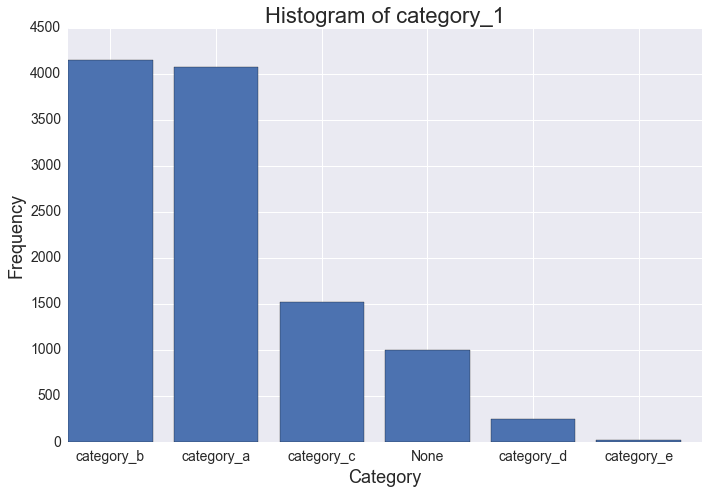

In [11]:
plt.bar(np.arange(category_hist_df.shape[0]), category_hist_df.freq)
plt.title('Histogram of category_1')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(np.arange(category_hist_df.shape[0]) + 0.4, category_hist_df.category_1)
plt.tight_layout()

## Numeric Values

In [12]:
numeric_hist_df = get_histogram_values('test_data', 'col_3', nbins=25)

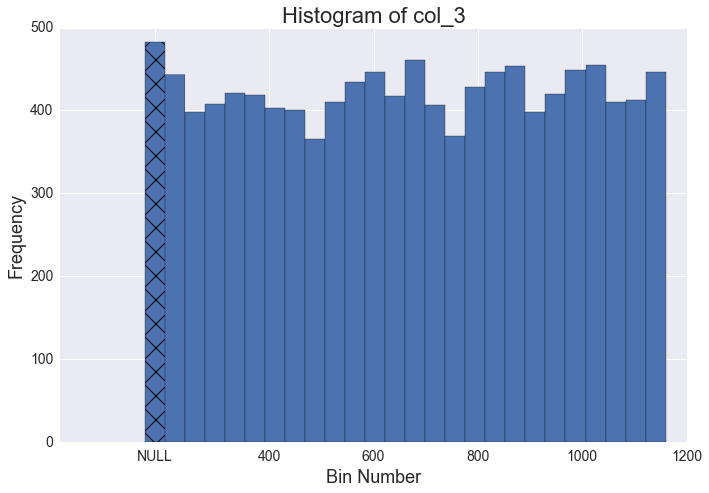

In [13]:
plot_numeric_hists(numeric_hist_df, nbins=25)
plt.title('Histogram of col_3')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

## Recasting values
If a numeric field is misrepresented as text.

In [14]:
recasted_hist_df = get_histogram_values('test_data', 'uncasted_col', nbins=25, cast_as='float')

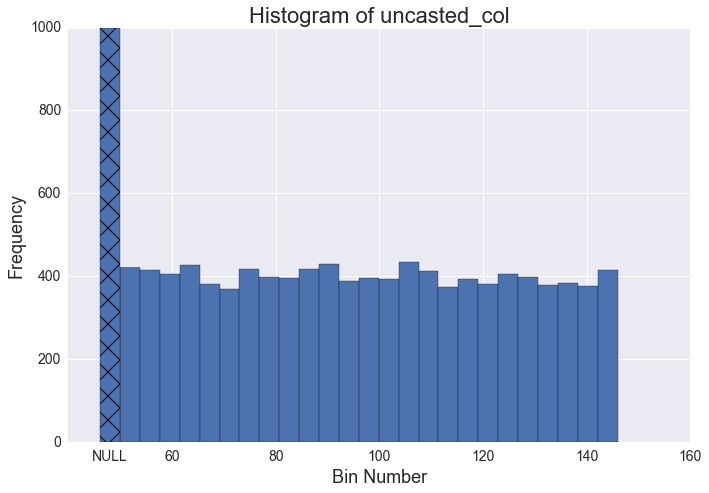

In [15]:
plot_numeric_hists(recasted_hist_df, nbins=25)
plt.title('Histogram of uncasted_col')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

## Plotting on a log scale

In [16]:
log_hist_df = get_histogram_values('test_data', 'log_col', nbins=25)

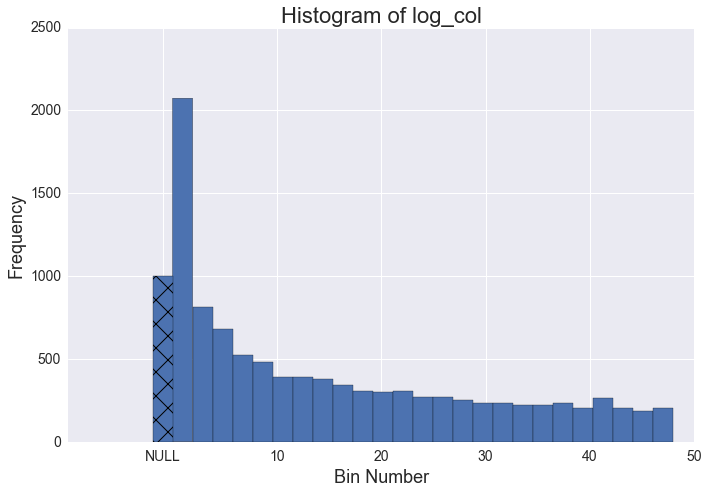

In [17]:
plot_numeric_hists(log_hist_df, nbins=25, log=False)
plt.title('Histogram of log_col')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

## Multiple Plots
Using the same syntax that is in matplotlib's hist function, we can also plot multiple histograms on the same plot.

In [18]:
df_1 = get_histogram_values('test_data', 'col_1', nbins=25)
df_2 = get_histogram_values('test_data', 'col_2', nbins=25)
df_3 = get_histogram_values('test_data', 'col_3', nbins=25)

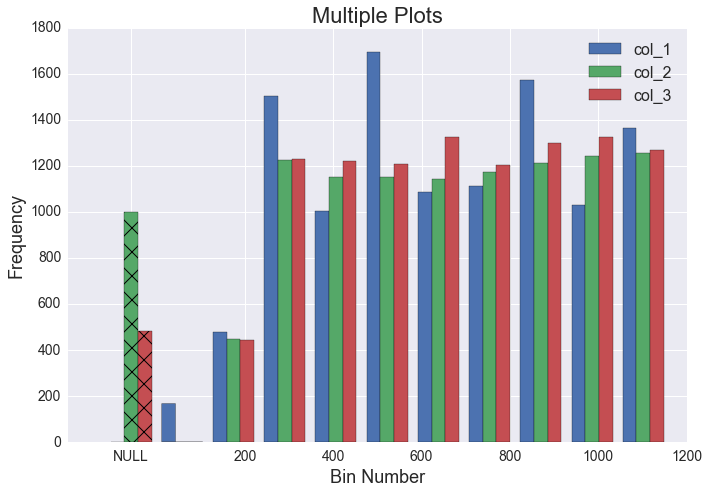

In [19]:
plot_numeric_hists([df_1, df_2, df_3], labels=['col_1', 'col_2', 'col_3'], nbins=10)
plt.title('Multiple Plots')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.legend(loc=0)
plt.tight_layout()

## Normalizing Plots
If we are plotting two or more histograms, they may be at different scales. For example, if we want to plot two histograms, but one has many more instances than the other, the smaller data set will not be visible on the histogram.

In [20]:
log_2_hist_df = get_histogram_values('small_test_data', 'log_col', nbins=25)

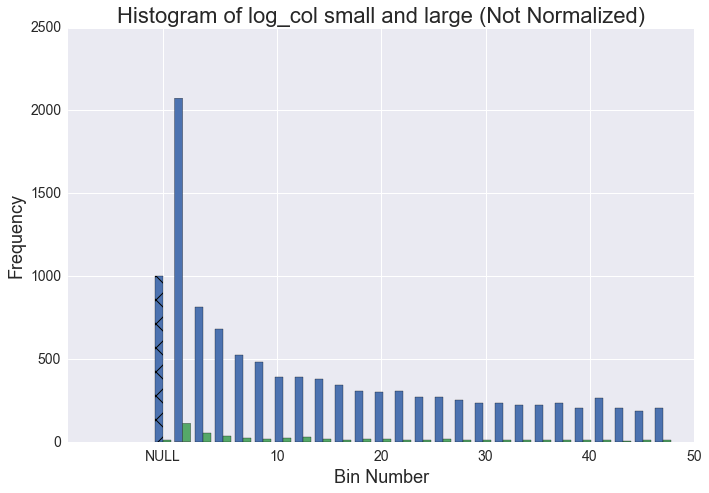

In [21]:
plot_numeric_hists([log_hist_df, log_2_hist_df], nbins=25, log=False, normed=False)
plt.title('Histogram of log_col small and large (Not Normalized)')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

The above plot illustrates the green, which is much smaller. There are a couple of things we can do. First, we can put everything onto the log scale.

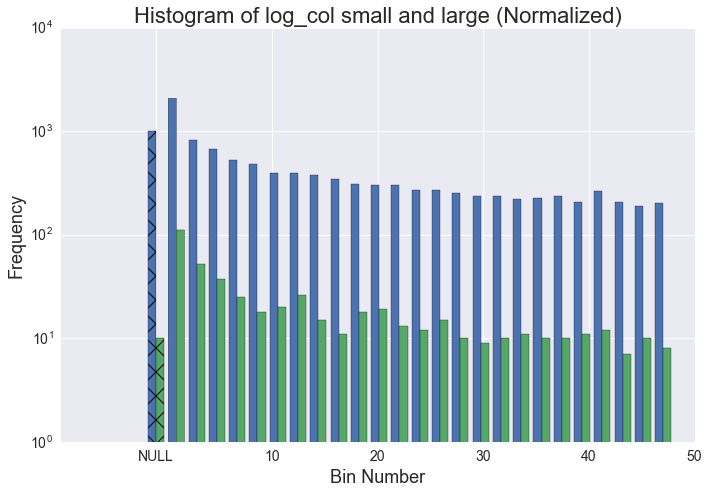

In [22]:
plot_numeric_hists([log_hist_df, log_2_hist_df], nbins=25, log=True, normed=False)
plt.title('Histogram of log_col small and large (Normalized)')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

Then, we can normalize it so that each variable has weights that sum to 1. In this way, it is much easier to compare percentages.

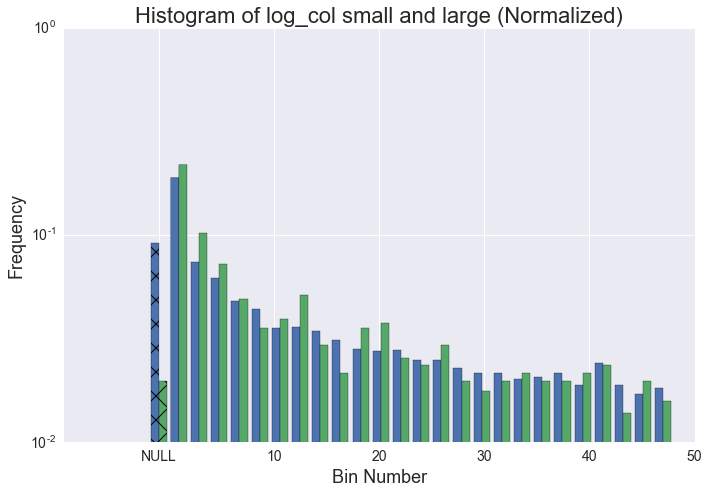

In [23]:
plot_numeric_hists([log_hist_df, log_2_hist_df], nbins=25, log=True, normed=True)
plt.title('Histogram of log_col small and large (Normalized)')
plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.tight_layout()

# Plot the Summarized Data as a Scatter Plot

## Make Sizes Relative to Amount of Data

In [24]:
scatter_df = get_scatterplot_values('test_data', 'col_1', 'col_2', nbins=(50, 50))

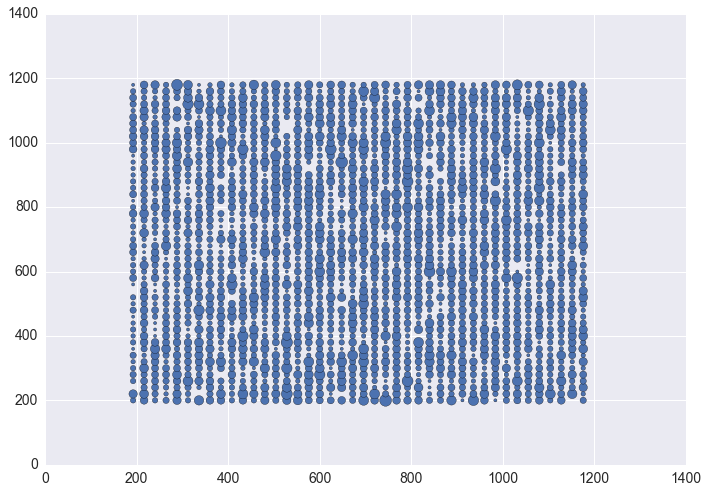

In [25]:
plt.scatter(scatter_df.bin_nbr_x, scatter_df.bin_nbr_y, c=blue, s=10*scatter_df.freq)
plt.tight_layout()

## Add Opacity

In [26]:
colour_matrix = np.zeros((scatter_df.dropna().shape[0], 4))
colour_matrix[:, :3] = blue
# Add alpha component
colour_matrix[:, 3] = scatter_df.dropna().freq/np.max(scatter_df.dropna().freq)

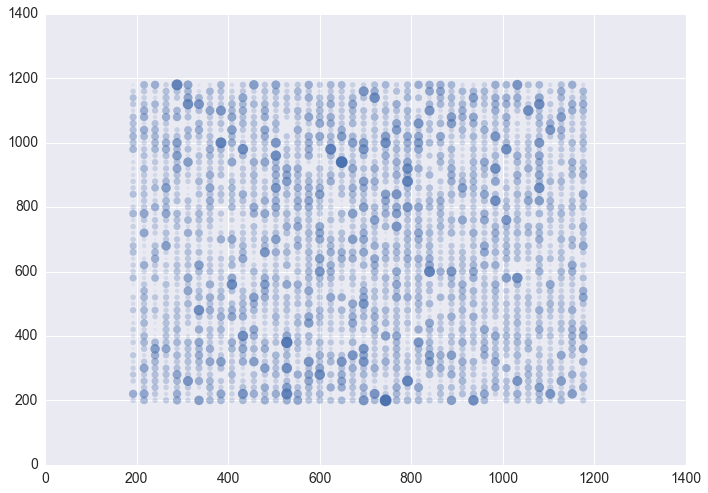

In [27]:
plt.scatter(scatter_df.bin_nbr_x, scatter_df.bin_nbr_y, c=colour_matrix, lw=0, s=10*scatter_df.freq)
plt.tight_layout()

# Casting
We can also cast values as before.

In [28]:
recasted_scatter_df = get_scatterplot_values('test_data', 'col_1', 'uncasted_col', nbins=(50, 50), cast_y_as='float')

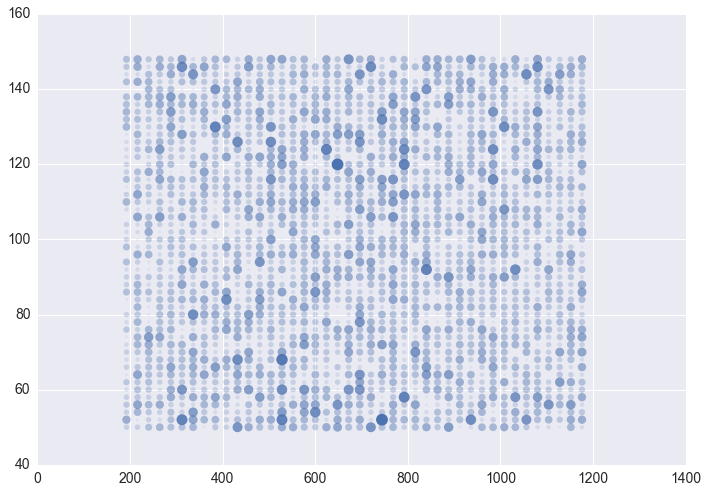

In [29]:
plt.scatter(recasted_scatter_df.bin_nbr_x, recasted_scatter_df.bin_nbr_y, c=colour_matrix, lw=0, s=10*scatter_df.freq)
plt.tight_layout()